In [ ]:
from math import *
from datetime import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from scipy.stats import norm
from scipy.interpolate import interp1d, RBFInterpolator
from scipy.optimize import curve_fit, least_squares, brentq
from sklearn.isotonic import IsotonicRegression

In [ ]:
R = 0.05  # risk-free rate for discounting
THETA_PARAMS = None  # to cache a,b,c after first fit
W_PARAMS = None  # to cache rho,eta after first fit

In [ ]:
def maturities_to_tj(date_str):
    """
    Converts a maturity date to time-to-maturity in years (ACT/365).
    Expiry is treated as end-of-day (23:59:59).

    Parameters:
        date_str (str): The maturity date in 'YYYY-MM-DD' format.
    Returns:
        float: Time to maturity in years.
    """
    today = datetime.today()
    maturity_date = datetime.strptime(date_str, '%Y-%m-%d').replace(
        hour=23, minute=59, second=59
    )
    delta = maturity_date - today
    tj = delta.total_seconds() / (365.0 * 24 * 3600)
    return tj

In [ ]:
def prep(df,expiry):
    """
    Prepares the options DataFrame by calculating the mid price, adding expiration date,
    and computing time to maturity.
    Args:
        df: DataFrame from yfinance option chain (calls or puts).
        expiry: expiration date string 'YYYY-MM-DD'.
    Returns:
        DataFrame with added 'mid', 'expirationDate', and 'tj' columns.
    """
    df = df.copy()
    mid = (df['bid'].fillna(0) + df['ask'].fillna(0)) / 2
    need_fallback = (mid == 0) | mid.isna()
    mid.loc[need_fallback] = df.loc[need_fallback, 'lastPrice']
    df['mid'] = mid
    df['expirationDate'] = expiry
    df['tj'] = maturities_to_tj(expiry)
    return df

In [ ]:
def compute_forwards(calls_df: pd.DataFrame, puts_df: pd.DataFrame, ticker_symbol: str, r: float, use_weights: bool = True):
    """
    Robust forward estimator per expiry using put-call parity across *many* strikes.

    Parity on forwards:  e^{rT}(C - P) = F - K  =>  F = K + e^{rT}(C - P).
    We estimate F_j for each expiry t_j by (optionally weighted) averaging K_i + e^{rT}(C_i - P_i)
    over all strikes common to calls & puts for that expiry.

    Args:
        calls_df, puts_df: dataframes from get_option_chain() (already have 'mid' and 'tj').
        ticker_symbol: for an ATM reference (weighting only).
        r: annual risk-free rate (continuously compounded).
        use_weights: if True, weight observations toward near-ATM strikes.

    Returns:
        forwards_df, calls_df_with_F, puts_df_with_F
    """

    # Spot only used to define "ATM-ish" weights (optional)
    spot = float(yf.Ticker(ticker_symbol).history(period='1d')['Close'].iloc[-1])

    expiries = sorted(set(calls_df['expirationDate']).intersection(set(puts_df['expirationDate'])))
    results = []

    # Pre-allocate F columns
    calls_df = calls_df.copy()
    puts_df  = puts_df.copy()
    calls_df['F'] = np.nan
    puts_df['F']  = np.nan

    for expiry in expiries:
        c_sub = calls_df[calls_df['expirationDate'] == expiry].copy()
        p_sub = puts_df[puts_df['expirationDate'] == expiry].copy()

        # Merge on common strikes
        merged = (c_sub[['strike','mid','tj']]
                  .merge(p_sub[['strike','mid']], on='strike', suffixes=('_c','_p')))

        if merged.empty:
            continue

        # Use the expiry's time-to-maturity
        T = float(merged['tj'].iloc[0])
        disc_inv = exp(r * T)          # e^{rT}
        y = disc_inv * (merged['mid_c'] - merged['mid_p'])  # ≈ F - K
        F_candidates = merged['strike'] + y                 # K + e^{rT}(C-P)

        # Optional: weight toward ATMish strikes for robustness
        if use_weights:
            # Distance from spot in log space is a decent proxy for vega shape
            k_abs = np.abs(np.log(np.maximum(1e-12, merged['strike'].values) / max(1e-12, spot)))
            # Smoothly cap extreme weights
            eps = 1e-3
            w = 1.0 / (k_abs + 0.10)  # slightly favors near-ATM without blowing up
        else:
            w = np.ones_like(F_candidates.values, dtype=float)

        # Weighted average forward for the expiry
        F_hat = float(np.average(F_candidates.values, weights=w))

        # Stash results and write F back into both frames for this expiry
        results.append({'expirationDate': expiry, 'tj': T, 'F': F_hat})
        calls_df.loc[calls_df['expirationDate'] == expiry, 'F'] = F_hat
        puts_df.loc[puts_df['expirationDate'] == expiry,  'F'] = F_hat

    forwards_df = pd.DataFrame(results).sort_values('tj').reset_index(drop=True)
    return forwards_df, calls_df, puts_df


In [ ]:
def bs_price(k,w,tj,F,type_o):
    """
    Calculate the Black-Scholes price of an option.

    Parameters:
        option_row (pd.Series): A row from the options DataFrame containing necessary fields.
    Returns:
        float: The Black-Scholes price of the option. This is a simplified version assuming zero dividends and constant risk-free rate.
    """

    w = max(float(w), 1e-16)
    s = sqrt(w)
    d1 = (-k/s)+0.5*s
    d2 = d1 - s

    c = norm.cdf(d1) - exp(k) * norm.cdf(d2)
    p = exp(k) * norm.cdf(-d2) - norm.cdf(-d1)
    DF = exp(-R * tj)
    C = DF * F * c
    P = DF * F * p
    return C if type_o == 'call' else P


In [ ]:
def clean_option_data(df):
    """
    Cleans the options DataFrame by removing rows with missing or invalid data.

    Parameters:
        df (pd.DataFrame): The options DataFrame to clean.
    Returns:
        pd.DataFrame: The cleaned options DataFrame.
    """
    df = df.copy()
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=['strike', 'impliedVolatility', 'mid', 'tj', 'F'])
    df = df[df['impliedVolatility'] > 0]
    df = df[df['mid'] > 1e-3]
    df = df[df['ask'] >= df['bid']]
    df = df[df['tj'] > 0]
    df = df[df['F'] > 0]

    df = df.reset_index(drop=True)

    return df

In [ ]:
def get_option_chain(ticker_symbol):
    """
    Fetches and returns the option chain for the given ticker symbol.

    Parameters:
        ticker_symbol (str): The stock ticker symbol.
    Returns:
        dict: A dictionary with 'calls' and 'puts' DataFrames.
    """

    ticker = yf.Ticker(ticker_symbol)
    expiries = ticker.options
    if not expiries:
        raise ValueError(f"No options data available for ticker symbol: {ticker_symbol}")
    all_calls = []
    all_puts = []

    for expiry in expiries:
        opt_chain = ticker.option_chain(expiry)
        calls = opt_chain.calls
        puts = opt_chain.puts

        all_calls.append(prep(calls, expiry))
        all_puts.append(prep(puts, expiry))

    all_calls_df = pd.concat(all_calls, ignore_index=True)
    all_puts_df = pd.concat(all_puts, ignore_index=True)

    calls_with_forwards = compute_forwards(all_calls_df, all_puts_df, ticker_symbol, r=R)
    all_calls_df = calls_with_forwards[1]
    all_puts_df = calls_with_forwards[2]

    # Log-moneyness
    all_calls_df['k'] = (all_calls_df['strike'] / all_calls_df['F']).apply(log)
    all_puts_df['k'] = (all_puts_df['strike'] / all_puts_df['F']).apply(log)

    # Total implied variance
    all_calls_df['w'] = (all_calls_df['impliedVolatility'] ** 2) * all_calls_df['tj']
    all_puts_df['w'] = (all_puts_df['impliedVolatility'] ** 2) * all_puts_df['tj']

    all_calls_df['type'] = 'call'
    all_puts_df['type'] = 'put'

    all_calls_df['bs_mid'] = all_calls_df.apply(lambda row: bs_price(row['k'], row['w'], row['tj'], row['F'], row['type']), axis=1)
    all_puts_df['bs_mid'] = all_puts_df.apply(lambda row: bs_price(row['k'], row['w'], row['tj'], row['F'], row['type']), axis=1)

    all_calls_df = clean_option_data(all_calls_df)
    all_puts_df = clean_option_data(all_puts_df)

    return {'calls': all_calls_df, 'puts': all_puts_df}

In [ ]:
def theta_atm_for_expiry(ks, ws):
    """
    Estimate θ(t_j) = w(0,t_j) by weighted linear interpolation in (k,w) at k=0.
    ks, ws: numpy arrays of log-moneynesses and total variances for a single expiry t_j.
    Returns: float θ(t_j) or np.nan if no data.
    """
    ks = np.asarray(ks, dtype=float)
    ws = np.asarray(ws, dtype=float)
    m = np.isfinite(ks) & np.isfinite(ws)
    ks, ws = ks[m], ws[m]
    if ks.size == 0:
        return np.nan

    # Focus near k=0 (adaptive window, but not too wide)
    abs_k = np.abs(ks)
    target = min(0.25, float(np.percentile(abs_k, 40)) if abs_k.size else 0.25)
    mask = abs_k <= max(0.05, target)
    ks_win, ws_win = ks[mask], ws[mask]
    if ks_win.size < 3:
        mask = abs_k <= min(0.35, max(0.15, target*1.5))
        ks_win, ws_win = ks[mask], ws[mask]
    if ks_win.size < 2:
        # last resort: median of closest few
        order = np.argsort(abs_k)
        take = min(len(order), max(3, len(order)//3 or 1))
        return float(np.median(ws[order[:take]]))

    # Bracketing interpolation if we have k<0 and k>0
    k_below = ks_win[ks_win < 0]
    k_above = ks_win[ks_win > 0]
    if k_below.size and k_above.size:
        k1 = k_below.max()
        k2 = k_above.min()
        # pick exact matches
        w1 = ws_win[np.where(ks_win == k1)[0][0]]
        w2 = ws_win[np.where(ks_win == k2)[0][0]]
        return float(w1 + (0.0 - k1) * (w2 - w1) / (k2 - k1 + 1e-16))

    # Fallback: linear interp in (k,w)
    uniq_k, idxs = np.unique(ks_win, return_inverse=True)
    if uniq_k.size >= 2:
        if uniq_k.size != ks_win.size:
        # average w for duplicate ks
            w_acc = np.zeros_like(uniq_k, dtype=float)
            c_acc = np.zeros_like(uniq_k, dtype=int)
            for i, u in enumerate(idxs):
                w_acc[u] += ws_win[i]; c_acc[u] += 1
            ws_use = w_acc / np.maximum(c_acc, 1)
        else:
            ws_use = ws_win
        f = interp1d(uniq_k, ws_use, kind='linear', fill_value='extrapolate', assume_sorted=True)
        return float(f(0.0))

    # Last fallback
    return float(np.median(ws_win))

In [ ]:
def build_theta(df):
    """
    Smooth ATM total variance curve θ(t) = w(0,t).
    Steps:
      1) For each expiry t, estimate θ_raw(t) via interpolation at k=0.
      2) Enforce monotone non-decreasing θ_iso(t) via isotonic regression.
      3) Fit smooth, monotone parametric curve θ(t) = a + b * t^c (a,b>=0, c>0),
         and return θ(t_j) evaluated at the listed expiries.

    Expects columns: ['tj','k','w']; optional ['bid','ask','mid'] for filtering.
    Returns: a, b, c
    """

    if not {'tj','k','w'}.issubset(df.columns):
        raise ValueError("DataFrame must contain 'tj','k','w'.")

    d = df.copy()
    d = d.replace([np.inf, -np.inf], np.nan).dropna(subset=['tj','k','w'])
    if 'ask' in d.columns and 'bid' in d.columns:
        d = d[(d['ask'] >= d['bid']).fillna(True)]
    if 'mid' in d.columns:
        d = d[(d['mid'] >= 1e-3).fillna(True)]

    # --- compute per-expiry θ_raw
    out = []
    for tj, g in d.groupby('tj'):
        g = g.sort_values('k')
        theta_raw = theta_atm_for_expiry(g['k'].to_numpy(), g['w'].to_numpy())
        out.append((float(tj), float(theta_raw)))
    thetas = pd.DataFrame(out, columns=['tj','theta_raw']).sort_values('tj').reset_index(drop=True)

    # --- enforce monotone non-decreasing via isotonic regression (no-arb baseline)
    ir = IsotonicRegression(increasing=True, out_of_bounds='clip')
    theta_iso = ir.fit_transform(thetas['tj'].to_numpy(float), thetas['theta_raw'].to_numpy(float))
    thetas['theta_iso'] = theta_iso

    # --- fit a smooth, monotone parametric curve θ(t) = a + b t^c with bounds
    def theta_model(t, a, b, c):
        t = np.asarray(t, dtype=float)
        t_pos = np.maximum(t, 1e-12)
        return a + b * (t_pos ** c)

    t_vals = thetas['tj'].to_numpy(float)
    y_vals = thetas['theta_iso'].to_numpy(float)

    # Initial guesses: a ≈ min θ, b ≈ (max-min), c ≈ 0.7 (concave-ish)
    a0 = max(0.0, float(np.nanmin(y_vals)))
    b0 = max(1e-8, float(np.nanmax(y_vals) - a0))
    c0 = 0.7

    try:
        popt, _ = curve_fit(theta_model, t_vals, y_vals,
                            p0=[a0, b0, c0],
                            bounds=([0.0, 0.0, 1e-3], [np.inf, np.inf, 2.0]),
                            maxfev=20000)
        theta_smooth = theta_model(t_vals, *popt)
    except Exception:
        # Fallback if optimizer struggles: just use θ_iso
        popt = (a0, b0, c0)
        theta_smooth = y_vals

    thetas['theta_smooth'] = theta_smooth

    return popt  # a, b, c

In [ ]:
def theta_function(t, a, b, c):
    """
    Parametric θ(t) = a + b * t^c
    """
    return a + b * (t ** c)

In [ ]:
def ssvi_sqrt(k, t, rho, eta, a, b, c):
    """
    SSVI total variance function w(k,t) = θ(t)/2 * (1 + ρφk + √((φk + ρ)^2 + (1 - ρ^2))
    where φ(t) = η / √θ(t), and θ(t) = a + b t^c.
    Args:
        k: log-moneyness (scalar or numpy array)
        t: time-to-maturity (scalar or numpy array)
        rho: correlation parameter (-1 < ρ < 1)
        eta: slope parameter (η > 0)
        a, b, c: parameters for θ(t)
    Returns:
        w: total implied variance (scalar or numpy array)
    """
    t = np.array(t)
    k = np.array(k)

    # Calculate theta(t) using vectorized operations
    theta_t = a + b * (t ** c)

    # Ensure theta_t is non-negative before taking the square root
    sqrt_theta = np.sqrt(np.maximum(theta_t, 1e-12))

    # Calculate phi(t)
    phi = eta / sqrt_theta

    # Use broadcasting for vectorized calculations
    term1 = 1.0 + rho * phi * k
    term2 = np.sqrt((phi * k + rho)**2 + (1 - rho**2))
    w = 0.5 * theta_t * (term1 + term2)

    return w

In [ ]:
def bs_cost(r, F, k, t, rho, eta, a, b, c, type_o):
    """
    Function to calculate the Black-Scholes price
    using the SSVI total variance for calibration.
    Args:
        r: risk-free rate (annualized, continuously compounded)
        F: forward price
        k: log-moneyness
        t: time-to-maturity
        rho: correlation parameter (-1 < ρ < 1)
        eta: slope parameter (η > 0)
        a, b, c: parameters for θ(t)
        type_o: 'call' or 'put'
    Returns:
        price: Black-Scholes price using SSVI total variance
    """
    w = ssvi_sqrt(k, t, rho, eta, a, b, c)
    w = max(float(w), 1e-16)
    d1 = (-k/sqrt(w))+0.5*sqrt(w)
    d2 = (-k/sqrt(w))-0.5*sqrt(w)
    call_norm = norm.cdf(d1) - exp(k)*norm.cdf(d2)
    put_norm = exp(k)*norm.cdf(-d2) - norm.cdf(-d1)
    DF = exp(-r*t)
    Call = DF * F * call_norm
    Put = DF * F * put_norm
    return Call if type_o == 'call' else Put

In [ ]:
def price_residuals(params, df):
    """
    Vectorized residuals function for least_squares fitting of (rho, eta).
    Uses global THETA_PARAMS = (a,b,c) for θ(t).
    Args:
        params: [rho, eta]
        df: DataFrame with at least ['k','tj','F','type','bs_mid']
    Returns:
        residuals: numpy array of model - market prices
    """
    if THETA_PARAMS is None:
        raise ValueError("THETA_PARAMS is not set. Call set_theta_params(a,b,c) first.")
    rho, eta = float(params[0]), float(params[1])
    a, b, c = THETA_PARAMS

    d = df[['k','tj','bs_mid','type','F']].replace([np.inf,-np.inf], np.nan).dropna()
    if d.empty:
        return np.zeros(0, dtype=float)

    ks  = d['k'].to_numpy(float)
    ts  = d['tj'].to_numpy(float)
    Fs  = d['F'].to_numpy(float)
    typ = d['type'].to_numpy(object)
    mkt = d['bs_mid'].to_numpy(float)

    # Vectorized evaluation via comprehension
    mdl = np.fromiter(
        (bs_cost(r=R, F=F, k=k, t=t, rho=rho, eta=eta, a=a, b=b, c=c, type_o=ty)
         for k,t,F,ty in zip(ks, ts, Fs, typ)),
        dtype=float, count=len(d)
    )
    return mdl - mkt

In [ ]:
def first_guess(df, x0=None, bounds=None, max_nfev=500, verbose=0):
    """
    Fit only (rho, eta) with fixed θ(t) stored in THETA_PARAMS.
    Uses vectorized price_residuals(params, df) → residuals (model - market).

    Args:
        df        : DataFrame with at least ['k','tj','F','type','bs_mid']
        x0        : optional initial guess [rho, eta]
        bounds    : optional ([rho_lo, eta_lo], [rho_hi, eta_hi])
        max_nfev  : max function evaluations
        verbose   : scipy verbosity (0,1,2)

    Returns:
        (x_hat, res): best-fit [rho, eta] and the OptimizeResult
    """
    if THETA_PARAMS is None:
        raise ValueError("THETA_PARAMS is not set. Call set_theta_params(a,b,c) first.")

    if x0 is None:
        x0 = np.array([-0.50, 1.00], dtype=float)
    else:
        x0 = np.asarray(x0, dtype=float)

    if bounds is None:
        lb = np.array([-0.999, 1e-6], dtype=float)
        ub = np.array([ 0.999, 5.0  ], dtype=float)
        bounds = (lb, ub)

    # price_residuals is already vectorized; pass it directly
    res = least_squares(
        price_residuals,
        x0=x0,
        bounds=bounds,
        args=(df,),
        max_nfev=max_nfev,
        verbose=verbose
    )

    x_hat = res.x if res.success else x0
    return x_hat, res

In [ ]:
def crossedness(params, df, num_points=200, delta_k=1, eps=1e-12, root_tol=1e-6):
    """
    Compute crossedness per maturity (Definition 5.1).
    First maturity's crossedness is defined as 0.0.

    Globals used:
      W_PARAMS = (rho, eta)
      THETA_PARAMS = (a, b, c)

    Returns:
      DataFrame with columns ['tj','crossedness'] where row j>0
      is Cross(t_{j-1}, t_j).
    """
    if THETA_PARAMS is None:
        raise ValueError("THETA_PARAMS must be set (a,b,c).")
    if 'tj' not in df.columns or 'k' not in df.columns:
        raise ValueError("df must contain 'tj' and 'k'.")

    rho, eta = float(params[0]), float(params[1])
    a, b, c = THETA_PARAMS

    # maturities
    t_unique = np.unique(df['tj'].to_numpy(float))
    t_unique.sort()
    if t_unique.size == 0:
        return pd.DataFrame(columns=['tj','crossedness'])

    # global k scan range (based on observed ks)
    k_obs = df['k'].to_numpy(float)
    k_min = float(np.nanmin(k_obs))
    k_max = float(np.nanmax(k_obs))

    out = [(float(t_unique[0]), 0.0)]  # first is defined as 0.0

    for idx in range(1, len(t_unique)):
        t1 = float(t_unique[idx - 1])
        t2 = float(t_unique[idx])

        # scan grid on the common observed range
        k_grid = np.linspace(k_min, k_max, num_points)

        # f(k) = w(t1,k) - w(t2,k)
        # ssvi_sqrt must accept vector k or broadcast via numpy
        f_vals = ssvi_sqrt(k_grid, t1, rho, eta, a, b, c) - ssvi_sqrt(k_grid, t2, rho, eta, a, b, c)
        f_vals = np.asarray(f_vals, dtype=float)
        f_vals[np.abs(f_vals) < eps] = 0.0  # treat tiny as zero

        # indices where sign changes between neighbors
        sign_prod = np.sign(f_vals[:-1]) * np.sign(f_vals[1:])
        brackets = np.where(sign_prod < 0)[0]
        zero_idx = np.where(f_vals == 0.0)[0]

        # collect roots: add exact-zero grid points, then refine brackets
        k_roots = []
        if zero_idx.size:
            k_roots.extend(k_grid[zero_idx].tolist())
        for j in brackets:
            a_k, b_k = k_grid[j], k_grid[j + 1]
            fa, fb = f_vals[j], f_vals[j + 1]
            try:
                # strict bracket only
                if fa * fb < 0.0:
                    r = brentq(
                        lambda kk: float(ssvi_sqrt(kk, t1, rho, eta, a, b, c) - ssvi_sqrt(kk, t2, rho, eta, a, b, c)),
                        a_k, b_k, maxiter=100
                    )
                    k_roots.append(float(r))
            except Exception:
                pass

        # deduplicate close roots
        if k_roots:
            k_roots = np.array(sorted(k_roots), dtype=float)
            merged = [k_roots[0]]
            for r in k_roots[1:]:
                if abs(r - merged[-1]) > root_tol:
                    merged.append(r)
            k_roots = np.array(merged, dtype=float)
        else:
            k_roots = np.array([], dtype=float)

        # Build mid-knots per Def. 5.1; clamp to [k_min,k_max]
        if k_roots.size >= 1:
            mid_knots = [max(k_min, min(k_max, k_roots[0] - delta_k))]
            for j in range(1, k_roots.size):
                mid_knots.append(0.5 * (k_roots[j - 1] + k_roots[j]))
            mid_knots.append(max(k_min, min(k_max, k_roots[-1] + delta_k)))
        else:
            # n=0 → crossedness is null; per definition, return 0 (no need to test ends)
            out.append((t2, 0.0))
            continue

        # c_i = max(0, w(t1,~k_i) - w(t2,~k_i)); crossedness = max_i c_i
        c_vals = []
        for kk in mid_knots:
            w1 = float(ssvi_sqrt(kk, t1, rho, eta, a, b, c))
            w2 = float(ssvi_sqrt(kk, t2, rho, eta, a, b, c))
            c_vals.append(max(0.0, w1 - w2))
        C = max(c_vals) if c_vals else 0.0

        out.append((t2, float(C)))

    return pd.DataFrame(out, columns=['tj','crossedness'])

In [ ]:
def butterfly_residuals(params, df):
    """
    Vectorized residuals function for least_squares fitting of (rho, eta)
    to enforce the butterfly arbitrage constraints of Gatheral & Jacquier (2014).
    Uses global THETA_PARAMS = (a,b,c) for θ(t).
    Args:
        params: [rho, eta]
        df: DataFrame with at least ['tj']
    Returns:
        residuals: numpy array of [ (1+|ρ|) φ(t) - 4, (1+|ρ|) φ(t)^2 - 4 ] at the longest maturity
    """
    if THETA_PARAMS is None:
        raise ValueError("THETA_PARAMS is not set. Call set_theta_params(a,b,c) first.")
    rho, eta = float(params[0]), float(params[1])
    a, b, c = THETA_PARAMS
    tj = df['tj'].to_numpy(float)
    theta_t = a + b * (tj ** c)
    theta_max = float(np.max(theta_t))
    v1 = max(0.0, eta*eta * (1.0+abs(rho)) - 4.0)
    v2 = max(0.0, eta * sqrt(max(theta_max,1e-16)) * (1.0+abs(rho)) - 4.0)
    return np.array([v1, v2], dtype=float)

In [ ]:
def net_residuals_per_slice(params, df, tj, scale_price=1.0, scale_butterfly=1.0, scale_calendar=1.0):
    """
    Combined residuals for a single maturity slice t_j:
      - price residuals for all options at t_j
      - butterfly arbitrage residuals at t_j
      - crossedness residual for slice t_j (0.0 if j=0)
    Args:
        params: [rho, eta]
        df: DataFrame with at least ['k','tj','F','type','bs_mid']
        tj: specific maturity to evaluate
    Returns:
        residuals: numpy array of concatenated residuals
    """
    d_slice = df[df['tj'] == tj]
    p_res = price_residuals(params, d_slice)
    b_res = butterfly_residuals(params, df)                  # shape (2,)
    c_res = crossedness(params, df)
    c_val = c_res[c_res['tj'] == tj]['crossedness'].to_numpy(float)
    c_vec = np.array([c_val[0] if c_val.size else 0.0], float)
    return np.concatenate([scale_price*p_res,
                       scale_butterfly*b_res,
                       scale_calendar*c_vec])

In [ ]:
def slice_fit(df, tj, x0=None, bounds=None, max_nfev=1000, verbose=0):
    """
    Fit (rho, eta) for a single maturity slice t_j with fixed θ(t_j).
    Uses net_residuals_per_slice(params, df, tj) → residuals (model - market + arb).
    Args:
        df        : DataFrame with at least ['k','tj','F','type','bs_mid']
        x0        : optional initial guess [rho, eta]
        bounds    : optional ([rho_lo, eta_lo], [rho_hi, eta_hi])
        max_nfev  : max function evaluations
        verbose   : scipy verbosity (0,1,2)
    Returns:
        (x_hat, res): best-fit [rho, eta] and the OptimizeResult
    """
    if THETA_PARAMS is None:
        raise ValueError("THETA_PARAMS is not set. Call set_theta_params(a,b,c) first.")

    if x0 is None:
        x0 = np.array([-0.50, 1.00], dtype=float)
    else:
        x0 = np.asarray(x0, dtype=float)

    if bounds is None:
        lb = np.array([-0.999, 1e-6], dtype=float)
        ub = np.array([ 0.999, 5.0  ], dtype=float)
        bounds = (lb, ub)

    # net_residuals_per_slice is already vectorized; pass it directly
    res = least_squares(
        net_residuals_per_slice,
        x0=x0,
        bounds=bounds,
        args=(df, tj),
        max_nfev=max_nfev,
        verbose=verbose
    )

    x_hat = res.x if res.success else x0
    return x_hat, res

In [ ]:
def plot_slice(df, tj, rho, eta, a, b, c, type_o='call', save=False):
    """
    Plot market vs model prices and implied volatilities for a single maturity slice t_j.
    Args:
        df: DataFrame with at least ['k','tj','F','type','bs_mid','impliedVolatility']
        tj: specific maturity to plot
        rho, eta: SSVI parameters for the slice
        a, b, c: parameters for θ(t)
        type_o: 'call' or 'put' to filter options
    Returns:
        None (displays plots)
    """
    d_slice = df[df['tj'] == tj]
    if d_slice.empty:
        print(f"No data for maturity tj={tj}")
        return
    ks = d_slice['k'].to_numpy(float)
    Fs = d_slice['F'].to_numpy(float)
    K = Fs * np.exp(ks)
    w_obs = d_slice['w'].to_numpy(float)
    w_est = ssvi_sqrt(ks, tj, rho, eta, a, b, c)
    bs_mid = d_slice['bs_mid'].to_numpy(float)
    bs_est = np.fromiter(
        (bs_cost(r=R, F=F, k=k, t=tj, rho=rho, eta=eta, a=a, b=b, c=c, type_o=ty)
         for k,F,ty in zip(ks, Fs, d_slice['type'].to_numpy(object))),
        dtype=float, count=len(d_slice)
    )

    # Subplot 1: Prices -> observed as points, model as line
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(K, bs_mid, label='Market Price', color='blue', alpha=0.6)
    plt.plot(K, bs_mid, label='Market Price', color='blue', alpha=0.6)
    plt.scatter(K, bs_est, label='SSVI Model Price', color='red', alpha=0.6)
    plt.plot(K, bs_est, label='SSVI Model Price', color='red', alpha=0.6)
    plt.title(f"Option Prices at tj={tj:.4f} years")
    plt.xlabel("Strike Price K")
    plt.ylabel("Black-Scholes Price")
    plt.legend()
    plt.grid(True)

    # Subplot 2: Total Variance -> observed as points, model as line
    plt.subplot(1, 2, 2)
    plt.scatter(ks, w_obs, label='Market Total Variance', color='blue', alpha=0.6)
    plt.plot(ks, w_obs, label='Market Total Variance', color='blue', alpha=0.6)
    plt.scatter(ks, w_est, label='SSVI Model Total Variance', color='red', alpha=0.6)
    plt.plot(ks, w_est, label='SSVI Model Total Variance', color='red', alpha=0.6)
    plt.title(f"Total Implied Variance at tj={tj:.4f} years")
    plt.xlabel("Log-Moneyness k")
    plt.ylabel("Total Implied Variance w")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if save:
        fn = f"option_slice_tj{tj:.4f}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        plt.savefig(fn, dpi=300)
        print(f"Saved option slice plot to {fn}")
    plt.show()

In [ ]:
def all_slices(df, rho, eta, a, b, c, type_o='call', plot=True, save=False):
    """
    Get w(k,t) slices for all maturities in df using SSVI parameters.
    Args:
        df: DataFrame with at least ['k','tj','type']
        rho, eta: SSVI parameters
        a, b, c: parameters for θ(t)
        type_o: 'call' or 'put' to filter options
        plot: if True, plot the slices
        save: if True, save the plot to a file
    Returns:
        DataFrame with columns ['tj','k','w'] for the slices
    """
    d = df[df['type'] == type_o].copy()
    if d.empty:
        print(f"No data for option type '{type_o}'")
        return

    t_unique = np.unique(d['tj'].to_numpy(float))
    if t_unique.size == 0:
        print("No maturities found in data.")
        return

    k_all = d['k'].to_numpy(float)
    k_lo = np.percentile(k_all, 1)
    k_hi = np.percentile(k_all, 99)
    ks = np.linspace(k_lo, k_hi, 400)

    Wkt = []

    if plot:
        from matplotlib.colors import Normalize
        from matplotlib.cm import ScalarMappable
        fig, ax = plt.subplots(figsize=(10, 6))
        norm = Normalize(vmin=float(np.min(t_unique)), vmax=float(np.max(t_unique)))
        cmap = plt.cm.viridis

    for tj in sorted(t_unique):
        w_est = ssvi_sqrt(ks, tj, rho, eta, a, b, c)
        if plot:
            color = cmap(norm(tj))
            ax.plot(ks, w_est, color=color, linewidth=1.5)
        Wkt.extend(zip([tj]*len(ks), ks.tolist(), w_est.tolist()))

    if plot:
        ax.set_title(f"SSVI Total Implied Variance Slices ({type_o.capitalize()}s)")
        ax.set_xlabel("Log-Moneyness k")
        ax.set_ylabel("Total Implied Variance w")
        ax.grid(True)
        sm = ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax); cbar.set_label('Maturity (years)')
        plt.tight_layout()
        if save:
            fn = f"w_slices_{type_o}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
            plt.savefig(fn, dpi=300)
            print(f"Saved w(k) slices plot to {fn}")
        plt.show()

    return pd.DataFrame(Wkt, columns=['tj','k','w'])

In [ ]:
def plot_w_surface(Wkt, save=False):
    """
    Plot the w(k,t) surface using RBF interpolation for smoothing.
    Args:
        Wkt: DataFrame with columns ['tj','k','w']
        save: if True, save the plot to a file
    Returns:
        None (displays plot)
    """
    if Wkt.empty:
        print("No data to plot for w(k,t) surface.")
        return

    # data
    tj = Wkt['tj'].to_numpy(float)
    k  = Wkt['k'].to_numpy(float)
    w  = Wkt['w'].to_numpy(float)

    # (important) scale features so k and t have comparable units
    k_mu, k_sd = np.mean(k), np.std(k) or 1.0
    t_mu, t_sd = np.mean(tj), np.std(tj) or 1.0
    X = np.column_stack([(k - k_mu)/k_sd, (tj - t_mu)/t_sd])

    # grid
    tj_grid = np.linspace(np.min(tj), np.max(tj), 150)
    k_grid  = np.linspace(np.min(k),  np.max(k),  150)
    k_mesh, tj_mesh = np.meshgrid(k_grid, tj_grid)
    Xg = np.column_stack([(k_mesh.ravel()-k_mu)/k_sd, (tj_mesh.ravel()-t_mu)/t_sd])

    # RBF fit (try kernel='thin_plate_spline' or 'multiquadric')
    rbf = RBFInterpolator(X, w, kernel='thin_plate_spline', smoothing=1e-3)
    w_mesh = rbf(Xg).reshape(k_mesh.shape)

    # plot
    fig = plt.figure(figsize=(12, 8))
    ax  = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(k_mesh, tj_mesh, w_mesh, cmap='viridis', edgecolor='none', alpha=0.9)
    ax.set_title('Total Implied Variance Surface w(k,t) — RBF smoothed')
    ax.set_xlabel('Log-Moneyness k')
    ax.set_ylabel('Maturity t (years)')
    ax.set_zlabel('Total Implied Variance w')
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=6)
    if save:
        fn = f"w_surface_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        plt.savefig(fn, dpi=300)
        print(f"Saved w(k,t) surface plot to {fn}")
    plt.show()

In [ ]:
def sigma_atm(t, a, b, c):
    """
    ATM implied volatility σ(0,t) = √(θ(t)/t)
    """
    theta_t = a + b * (t ** c)
    return np.sqrt(np.maximum(theta_t / t, 0.0))

# Tests

## 1. Set the ticker Symbol in the next **cell**

In [ ]:
ticker_symbol = 'AAPL'

## 2. Get the Option Chain along with other required fields

In [ ]:
calls_and_puts = get_option_chain(ticker_symbol)
calls = calls_and_puts['calls']
puts = calls_and_puts['puts']

all_options = pd.concat([calls, puts], ignore_index=True)

## 3. Build a monotonic function for θ

$\theta(t) = a + b t^c$

In [ ]:
a, b, c = build_theta(all_options)
THETA_PARAMS = (a, b, c)
print(f"Fitted theta params: a={a:.6f}, b={b:.6f}, c={c:.6f}")

Fitted theta params: a=0.001837, b=0.062090, c=1.193373


## 4. Fit over the entire k,θ region for the first guess of w(k,θ)

$w(k,θ) = \frac{θ}{2}\left[1+\rho\phi(\theta)k+\sqrt{(\phi(\theta)k+\rho)^2+(1-\rho^2)}\right]$

$\phi(\theta) = \frac{\eta}{\sqrt{\theta}}$

In [ ]:
initial_guess = [-0.5, 1.0]
(rho_hat, eta_hat), result = first_guess(all_options, x0=initial_guess, verbose=0)
print(f"Fitted SSVI params (first guess): rho={rho_hat:.6f}, eta={eta_hat:.6f}")
W_PARAMS = (rho_hat, eta_hat)

Fitted SSVI params (first guess): rho=-0.312352, eta=1.471600


## 5. Fit w slice by slice by adding penalties for calendar arbitrage and butterfly arbitrage

### Calendar Arbitrage Condition
Calendar arbitrage happens when option prices across different maturities are inconsistent, so you could lock in a risk-free profit by buying and selling options with the same strike but different expiries.

This happens when the implied total variance surface violates the basic rule that variance should be non-decreasing with maturity, in other words, if a short-dated option looks “more expensive” in variance terms than a longer-dated option at the same strike, you can arbitrage the difference.

i.e. To avoid calendar arbitrage the following condition must be true:

$C(k,t_2)>C(k,t_1) \forall t_2>t_1$

or

$\frac{\partial C}{\partial t}\ge 0$

which is the same as saying:

$\frac{\partial w}{\partial t}\ge 0$

In this case this is avoided by minimizing the "crossedness" of any two slices of w.

Crossedness is defined as follows:

1. Find all the points where the slice $t_i$ and $t_{i-1}$ intersect. Let this be the set $\left\{k: k \textrm{ is a root of } w(k,t_{i-1})-w(k,t_i)=0\right\}$ and $|K|\le4$
1. Find the set of "mid-knots" $K'$ as follows (here I have set Δ to 1 as per Gatheral & Jaquier (2014)):
    - $k'_1=k_1-\Delta$
    - $k'_i=\frac{1}{2} (k_i+k_i$<sub>-1</sub>)
    - $k'_n=k_n+\Delta$
1. Define the crossedness of slice i as:

    $C = \max[\max[0,w(k'_j,t_{i-1})-w(k'_j,t_i)]]$
     where $k'_j \in K'$

### Butterfly Arbitrage Condition
Butterfly arbitrage is when option prices across strikes for the same maturity are inconsistent, so you could lock in a risk-free profit using a butterfly spread. A butterfly spread for a call option is 1 low strike long call, 1 high strike long call and 2 mid strike short calls.

This happens when the implied volatility smile is shaped in a way that makes the option price curve non-convex in strike, in other words, if the second derivative of call prices with respect to strike goes negative, it signals an arbitrage.

i.e. To avoid butterfly arbitrage, the following condition must be true:

$C(K_2,t)\ge \lambda C(K_1,t)-(1-\lambda)C(K_3,t)$ where $\lambda = \frac{K_3 - K_2}{K_3 - K_1}$

or

$\frac{\partial^2C}{\partial K^2}\ge 0$

which is the same as saying:

$q\ge 0$ where q is the risk-neutral probability density

In this case we use the specific butterfly arbitrage conditions for an SSVI from Gatheral & Jaquier (2014):

1. $\theta\phi(\theta)(1+|\rho|)<4$
1. $\theta\phi^2(\theta)(1+|\rho|)\le4$

This is implemented by minimizing $\max(\theta\phi(\theta)(1+|\rho|)-4,0)$ and $\max(\theta\phi^2(\theta)(1+|\rho|)-4,0)$

In [ ]:
t = sorted(all_options['tj'].unique())

slice_results = []

for tj in t:
    (rho_j, eta_j), res_j = slice_fit(all_options, tj, x0=[rho_hat, eta_hat], verbose=0)
    slice_results.append((tj, rho_j, eta_j))

slices_df = pd.DataFrame(slice_results, columns=['tj','rho','eta'])
print(slices_df)

          tj       rho       eta
0   0.016890 -0.998997  0.027758
1   0.016890 -0.999000  0.208024
2   0.036068 -0.999000  0.028016
3   0.036068 -0.777271  0.403325
4   0.055246 -0.999000  0.059566
5   0.055246 -0.440754  0.953530
6   0.074424 -0.999000  0.145243
7   0.074424 -0.404437  1.193593
8   0.093602 -0.999000  0.248822
9   0.093602 -0.413084  1.517305
10  0.112781 -0.999000  0.214384
11  0.112781 -0.392109  1.509527
12  0.189493 -0.522755  0.652709
13  0.189493 -0.375414  1.824439
14  0.266205 -0.999000  0.384352
15  0.266205 -0.402242  1.890833
16  0.342918 -0.999000  0.369350
17  0.342918 -0.432517  1.959148
18  0.438808 -0.999000  0.429873
19  0.438808 -0.399474  2.000279
20  0.515520  0.367041  2.696305
21  0.515520 -0.427933  1.993855
22  0.592233 -0.999000  0.335732
23  0.592233 -0.395777  1.973347
24  0.668945 -0.999000  0.427786
25  0.668945 -0.429156  2.032628
26  0.762096  0.132419  1.867190
27  0.762096 -0.398668  2.141012
28  0.937438 -0.999000  0.317507
29  0.9374

## Plotting Steps

### 1. Individual Slices - Plot of prices and total variance vs k at each maturity

### Set this to True to plot all individual slices ⬇

In [ ]:
plot_individual_slices_bool = False

### Set this to True to save all individual slices as pngs ⬇

In [ ]:
save_individual_slices_bool = False

In [ ]:
if plot_individual_slices_bool:
  for idx, row in slices_df.iterrows():
      tj, rho_j, eta_j = row['tj'], row['rho'], row['eta']
      print(f"Plotting slice for tj={tj:.4f}, rho={rho_j:.6f}, eta={eta_j:.6f}")
      plot_slice(all_options, tj, rho_j, eta_j, a, b, c, type_o='call', save=save_indvidual_slices_bool)


### 2. All slices - Plot of all maturity total variance slices vs k

### Set this to True to plot all slices ⬇

In [ ]:
plot_all_slices_bool = True

### Set this to True to save the plot as a png ⬇

In [ ]:
save_all_slices_bool = False

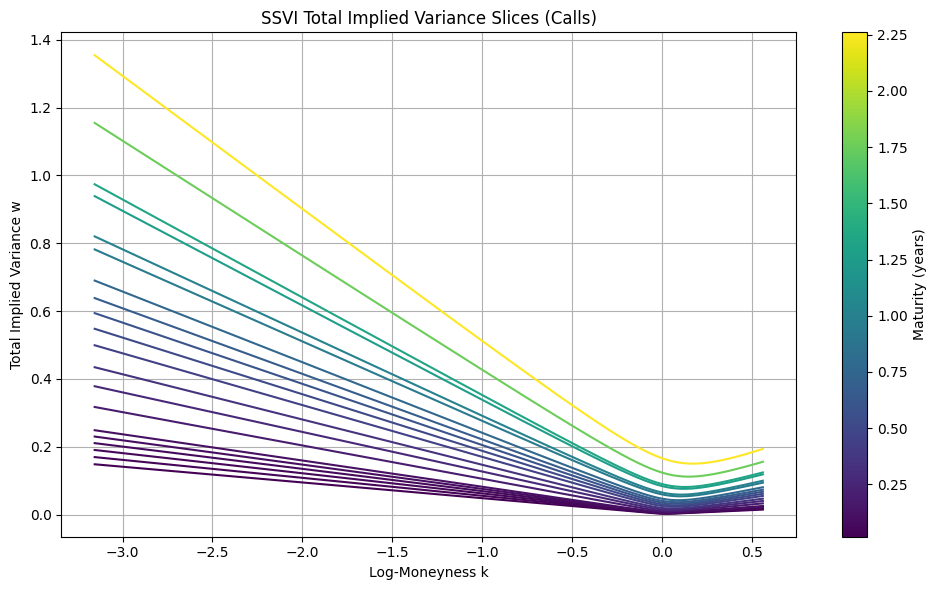

In [ ]:
Wkt = all_slices(all_options, rho_hat, eta_hat, a, b, c, type_o='call', plot=plot_all_slices_bool, save=save_all_slices_bool)

### 3. Full variance surface - plot of w vs k vs t

### Set this to True to plot the variance surface ⬇

In [ ]:
plot_surface_bool = True

### Set this to True to save the surface plot as a png ⬇

In [ ]:
save_surface_bool = False

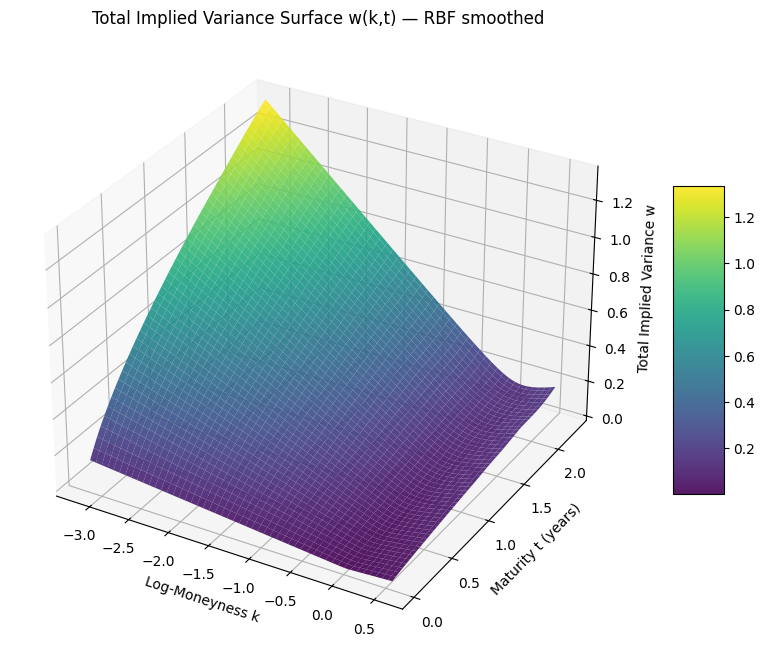

In [ ]:
if plot_surface_bool:
  plot_w_surface(Wkt, save=save_surface_bool)